<a href="https://colab.research.google.com/github/marcobiagetti/Rcodes/blob/master/DC01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_path = '/content/drive/MyDrive/train'
test_path = '/content/drive/MyDrive/test'

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [3]:
import os

train_fraud = len(os.listdir('/content/drive/MyDrive/train/Fraud'))
train_nonfraud = len(os.listdir('/content/drive/MyDrive/train/Non-Fraud'))

print(f"Train - Fraud: {train_fraud} immagini")
print(f"Train - Non-Fraud: {train_nonfraud} immagini")


Train - Fraud: 372 immagini
Train - Non-Fraud: 6091 immagini


In [7]:
test_fraud = len(os.listdir('/content/drive/MyDrive/test/Fraud'))
test_nonfraud = len(os.listdir('/content/drive/MyDrive/test/Non-Fraud'))

print(f"Test - Fraud: {test_fraud} immagini")
print(f"Test - Non-Fraud: {test_nonfraud} immagini")


Test - Fraud: 93 immagini
Test - Non-Fraud: 1523 immagini


In [4]:
# Durante il training, di solito si normalizzano i dati usando solo il training set,
# per evitare data leakage (cioè usare inconsapevolmente informazioni future).
# Quando viene fatta la valutazione sul test, si normalizza usando le statistiche calcolate sul training,
# così il modello vede i dati test "come se fossero nuovi".
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# 1: trasformazione senza normalizzazione
# 224,224 è una dimensione standard estremamente comune per le immagini
# 128,128 sono più piccole quindi più veloci ma meno dettagliate
#256, 256 più grandi, più dettagliate ma troppa RAM e GPU utilizzate
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2: caricamento del dataset train
# batch_samples=32 è un numero standard per caricare più immagini per volta durante il training o il preprocessing.
# Significa che il DataLoader carica 32 immagini in ogni gruppo (batch), e poi il ciclo for le elabora insieme.
# Puoi cambiarlo a 16, 64, o anche 8 a seconda della RAM/VRAM disponibile

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


# 3: calcolo di media e scarto quadratico medio
mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tqdm(train_loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # [gruppi/batch, canali, altezza*larghezza]
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Media: {mean}")
print(f"Scarto quadratico medio: {std}")
# Ci sono 3 valori perché i canali sono 3: Rosso, Verde, Blu
# Una deviazione standard attorno a 0.22 è normalissima per immagini reali


100%|██████████| 202/202 [37:28<00:00, 11.13s/it]

Media: tensor([0.4784, 0.4586, 0.4585])
Scarto quadratico medio: tensor([0.2207, 0.2195, 0.2211])


In [5]:
#Trasformazioni e normalizzazione utilizzando le 3 medie e le 3 deviazioni standard calcolate sopra
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4784, 0.4586, 0.4585], std=[0.2207, 0.2195, 0.2211])
])


In [6]:
# Rete neurale convoluzionale, CNN con feature-extractor (senza classificatore finale)
# Immagine presa, analizzata attraverso convoluzioni, ReLu e pooling
# Produzione finale di un vettore
# In questo caso viene utilizzata ResNet18 come "spremi-immagini",
# ma si toglie l’ultimo strato pienamente connesso (quello che fa la classificazione),
# perché non si vuol dire “fraud” o “non-fraud”, ma solo ottenere le informazioni utili dall'immagine.
# ResNet18 è un modello di deep learning pre-addestrato su milioni di immagini (ImageNet),
# che serve per estrarre automaticamente le caratteristiche (feature) da immagini.
# Fa parte della famiglia ResNet (Residual Networks), creata da Microsoft nel 2015
# In pratica è una rete neurale convoluzionale profonda.
# Il "18" indica che ha 18 strati.
# È leggera e perfetta per iniziare a fare feature extraction su nuove immagini, come ad esempio in frode/non frode.
# Funziona benissimo anche per dataset non enormi.
# Alla fine tira fuori il vettore numerico delle caratteristiche dalle immagini

import torch.nn as nn
import torchvision.models as models

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # rimozione del classificatore finale, tutti gli strati di ResNet18. Prende tutti, tranne l'ultimo [:-1] e quindi esclude il classificatore finale

    def forward(self, x):
        x = self.backbone(x)
        return x.view(x.size(0), -1)  # appiattimento dell'immagine
# Quando si passa un’immagine nella ResNet (senza classificatore), si ottiene un tensor 3D con dimensioni tipo [batch_size, channels, 1, 1].
# Per usare queste feature come input per KMeans o un altro modello, si ha bisogno di un vettore 1D per immagine.
# view(x.size(0), -1) appiatta (flatten) l’immagine: da [batch_size, 512, 1, 1] a [batch_size, 512].
# view() è come reshape() in NumPy



In [9]:
# Approccio	Descrizione breve
# DEC (Deep Embedded Clustering)	Apprende una rappresentazione latente e la clusterizza con KMeans iterativo.
# IDEC (Improved DEC)	Come DEC, ma con una ricostruzione autoencoder che ci aiuta a mantenere la struttura.
# VaDE (Variational Deep Embedding)	Combina VAE con GMM, con prior sui cluster.
# Pipeline Feature + KMeans	Estrai feature con ResNet → applichi KMeans direttamente su di esse.

# LINEA 1
# ResNet + KMeans
# Salvo i vettori delle caratteristiche (feature)
# Carico le immagini con normalizzazione usando la media e dev st calcolate.
# Estraggo le feature da ResNet18 senza classificatore.
# Salvo i vettori delle immagini in due array: uno per le immagini, uno per le etichette (fraud / non-fraud).
# Applico KMeans.
# Poi grafico le due dimensioni

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 202/202 [11:30<00:00,  3.42s/it]


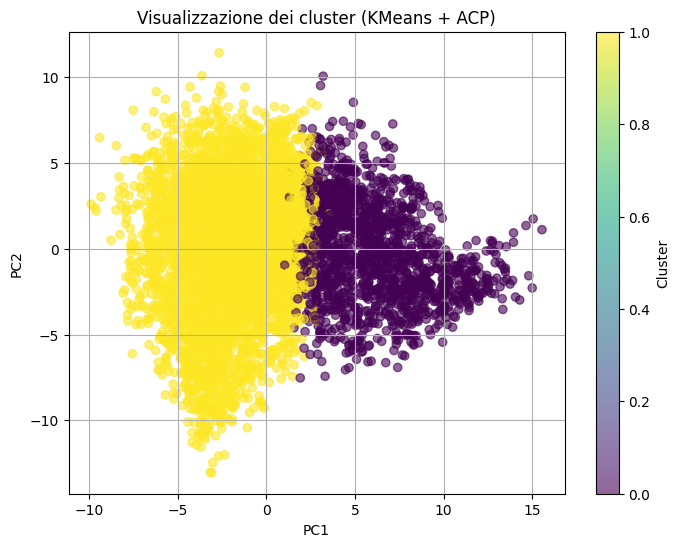

In [11]:
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm



# 2. Inizializzo rete ed entro in modalità eval(uation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeatureExtractor().to(device)
model.eval()

# 3. Estraggo le caratteristiche da tutte le immagini nel train_loader
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        features = model(images)
        all_features.append(features.cpu())
        all_labels.append(labels)

# 4. Concateno tutto in un unico tensore
features_matrix = torch.cat(all_features).numpy()
labels_array = torch.cat(all_labels).numpy()

# 5. Raggruppamento (clustering) con KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_matrix)

# 6. Riduco a 2D con ACP per la visualizzazione
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_matrix)

# 7. Visualizzo i cluster
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Visualizzazione dei cluster (KMeans + ACP)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


In [12]:
# Etichette
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        features = model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

X = np.concatenate(all_features)
true_labels = np.concatenate(all_labels)


In [13]:
# Kmeans applicata
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
predicted_clusters = kmeans.fit_predict(X)


In [15]:
# Mappatura dei cluster con etichette vere

from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_clusters)

# Trovo la migliore associazione dei cluster
# (massimo valore su ogni colonna)
mapping = np.argmax(cm, axis=0)

# Converto i cluster nei valori reali
mapped_predictions = np.array([mapping[c] for c in predicted_clusters])


In [17]:
# Calcolo accuratezza

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, mapped_predictions)
print(f"Accuratezza del clustering: {accuracy:.2%}")


Accuratezza del clustering: 94.24%


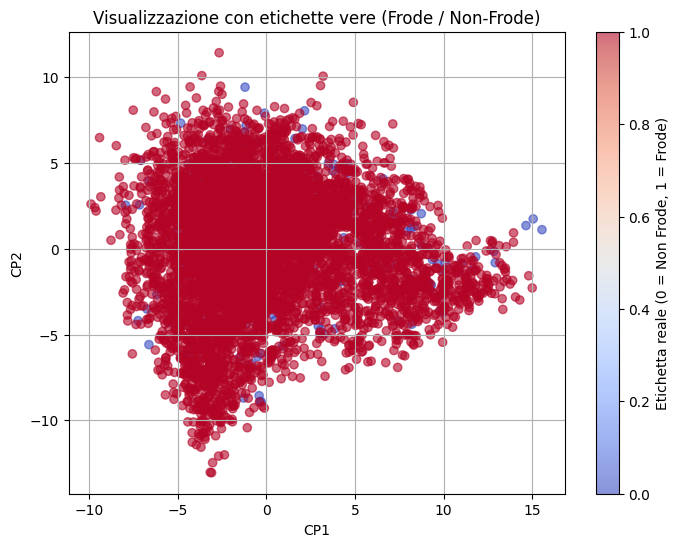

In [18]:
#Visualizzazione con etichette vere

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='coolwarm', alpha=0.6)
plt.title("Visualizzazione con etichette vere (Frode / Non-Frode)")
plt.xlabel("CP1")
plt.ylabel("CP2")
plt.colorbar(scatter, label="Etichetta reale (0 = Frode, 1 = Non Frode)")
plt.grid(True)
plt.show()


In [20]:
y_test = []
for _, labels in test_loader:
    y_test.extend(labels.numpy())

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(93), np.int64(1): np.int64(1523)}


In [17]:
# 1. Estraggo le caratteristiche dalle immagini di test
all_features_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        features = model(images)
        all_features_test.append(features.cpu())
        all_labels_test.append(labels)

# 2. Concateno le caratteristiche estratte per il set di test
features_matrix_test = torch.cat(all_features_test).numpy()
labels_array_test = torch.cat(all_labels_test).numpy()

# 3. Applico KMeans sui dati di test
predicted_clusters_test = kmeans.predict(features_matrix_test)

# 4. Mappo i cluster predetti alle etichette reali (fraud / non-fraud)
cm_test = confusion_matrix(labels_array_test, predicted_clusters_test)

# Trovo la migliore associazione dei cluster (mappatura)
mapping_test = np.argmax(cm_test, axis=0)

# Converto i cluster nei valori reali
mapped_predictions_test = np.array([mapping_test[c] for c in predicted_clusters_test])

# 5. Calcolo l'accuratezza sui dati di test
accuracy_test = accuracy_score(labels_array_test, mapped_predictions_test)
print(f"Accuratezza sui dati di test: {accuracy_test:.2%}")

# 6. Visualizzo dei dati di test con etichette vere
pca_test = PCA(n_components=2)
X_pca_test = pca_test.fit_transform(features_matrix_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=labels_array_test, cmap='coolwarm', alpha=0.6)
plt.title("Visualizzazione dei dati di test con etichette vere (Frode / Non Frode)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Etichetta reale (0 = Frode, 1 = Non Frode)")
plt.grid(True)
plt.show()


NameError: name 'torch' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import torch
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Estrazione delle caratteristiche dalle immagini di test
all_features_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):  # Assicurati che 'test_loader' sia definito
        images = images.to(device)
        features = model(images)  # 'model' è il tuo modello di deep learning
        all_features_test.append(features.cpu())
        all_labels_test.append(labels)

# 2. Concatenazione delle caratteristiche estratte per il set di test
features_matrix_test = torch.cat(all_features_test).numpy()
labels_array_test = torch.cat(all_labels_test).numpy()

# 3. Applicazione di KMeans sui dati di test
predicted_clusters_test = kmeans.predict(features_matrix_test)

# 4. Mappatura dei cluster predetti alle etichette reali (fraud / non-fraud)
cm_test = confusion_matrix(labels_array_test, predicted_clusters_test)

# Trova la migliore associazione dei cluster (mappatura)
mapping_test = np.argmax(cm_test, axis=0)

# Converte i cluster nei valori reali
mapped_predictions_test = np.array([mapping_test[c] for c in predicted_clusters_test])

# 5. Calcolo dell'accuratezza sui dati di test
accuracy_test = accuracy_score(labels_array_test, mapped_predictions_test)
print(f"Accuratezza sui dati di test: {accuracy_test:.2%}")

# 6. Calcolo della precisione, recall, e F1-score
precision_test = precision_score(labels_array_test, mapped_predictions_test)
recall_test = recall_score(labels_array_test, mapped_predictions_test)
f1_test = f1_score(labels_array_test, mapped_predictions_test)

print(f"Precisione sui dati di test: {precision_test:.2f}")
print(f"Recall sui dati di test: {recall_test:.2f}")
print(f"F1-score sui dati di test: {f1_test:.2f}")

# 7. Calcolo dell'AUC (area sotto la curva ROC) per il modello binario
# Nota: Per calcolare AUC, è necessario che il modello restituisca probabilità per le classi
# Assicurati che le probabilità siano estratte correttamente
# y_prob_test = model(torch.tensor(features_matrix_test).to(device)).cpu().detach().numpy() # Questo è sbagliato
# Invece d'inserire features_matrix_test, che contiene le caratteristiche estratte,
# bisogna inserire le immagini originali per ottenere le probabilità
# in altri termini non un tensore a 2D ma uno a 4D
# iterazione in test_loader per ottenere le immagini originali
# immagini inserite nel modello
# calcolo probabilità
# estrazione probabilità
y_prob_test = []
with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1) # calcolo probabilità con softmax
        y_prob_test.extend(probabilities[:, 1].cpu().numpy()) # Ottengo probabilità (fraud)

y_prob_test = np.array(y_prob_test) # Converto la lista in array Numpy
auc_test = roc_auc_score(labels_array_test, y_prob_test)
print(f"AUC sui dati di test: {auc_test:.2f}")

# 8. Visualizzazione dei dati di test con etichette vere
pca_test = PCA(n_components=2)
X_pca_test = pca_test.fit_transform(features_matrix_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=labels_array_test, cmap='coolwarm', alpha=0.6)
plt.title("Visualizzazione dei dati di test con etichette vere (Frode / Non Frode)")
plt.xlabel("CP1")
plt.ylabel("CP2")
plt.colorbar(scatter, label="Etichetta reale (0 = Frode, 1 = Non Frode)")
plt.grid(True)
plt.show()


In [13]:
import torch
import torch.optim as optim
import torchvision.models as models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Modello DEC
class DEC(nn.Module):
    def __init__(self, feature_extractor, n_clusters=2, alpha=1.0):
        super(DEC, self).__init__()
        self.feature_extractor = feature_extractor
        self.cluster_layer = nn.Linear(512, n_clusters)  # 512 è la dimensione di output di ResNet18
        self.alpha = alpha

    def forward(self, x):
        features = self.feature_extractor(x)
        cluster_probs = self.cluster_layer(features)
        return cluster_probs, features

    def compute_cluster_loss(self, cluster_probs, target_probs):
        # Computa la perdita per il DEC, che combina l'entropia incrociata con la distanza rispetto ai target probabilistici
        return torch.mean(torch.sum(target_probs * torch.log(cluster_probs + 1e-10), dim=1))

    def compute_target_probs(self, cluster_probs, target_labels, n_clusters):
        # Calcola i target probabilistici, utilizzando i centri dei cluster
        target_probs = torch.zeros_like(cluster_probs).to(cluster_probs.device)
        for i in range(len(target_labels)):
            target_probs[i, target_labels[i]] = 1.0
        return target_probs

# Funzione di allenamento DEC
def train_DEC(model, train_loader, optimizer, n_epochs=10):
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            optimizer.zero_grad()

            cluster_probs, _ = model(images)
            target_probs = model.compute_target_probs(cluster_probs, labels, n_clusters=2)  # Usa le etichette (fraud, non-fraud)

            loss = model.compute_cluster_loss(cluster_probs, target_probs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Pre-processamento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4784, 0.4586, 0.4585], std=[0.2207, 0.2195, 0.2211])
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Estrazione delle feature con ResNet18
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])

    def forward(self, x):
        x = self.backbone(x)
        return x.view(x.size(0), -1)

# Decodificatore DEC
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = FeatureExtractor().to(device)
dec_model = DEC(feature_extractor, n_clusters=2).to(device)

optimizer = optim.Adam(dec_model.parameters(), lr=1e-4)

# Allenamento DEC
train_DEC(dec_model, train_loader, optimizer, n_epochs=10)

# Estrazione caratteristiche
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        features = dec_model.feature_extractor(images)
        all_features.append(features.cpu())
        all_labels.append(labels)

features_matrix = torch.cat(all_features).numpy()
labels_array = torch.cat(all_labels).numpy()

# Riduzione dimensionale con ACP per visualizzazione
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_matrix)

# Visualizzazione dei cluster con ACP
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_array, cmap='coolwarm', alpha=0.6)
plt.title("Visualizzazione del clustering (DEC) con ACP")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Etichette vere (0 = Frode, 1 = Non Frode)")
plt.grid(True)
plt.show()


AttributeError: partially initialized module 'torch' has no attribute 'nn' (most likely due to a circular import)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# Calcolare la confusion matrix
cm = confusion_matrix(true_labels, mapped_predictions)

# Troviamo la migliore associazione dei cluster
# (massimo valore su ogni colonna)
mapping = np.argmax(cm, axis=0)

# Convertiamo i cluster nei valori reali
mapped_predictions = np.array([mapping[c] for c in predicted_clusters])

# Calcoliamo precisione, recall, F1 e accuracy
precision = precision_score(true_labels, mapped_predictions)
recall = recall_score(true_labels, mapped_predictions)
f1 = f1_score(true_labels, mapped_predictions)
accuracy = accuracy_score(true_labels, mapped_predictions)

print(f"Precisione: {precision:.2f}")
print(f"Richiamo: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Accuratezza: {accuracy:.2f}")

# AUC - Calcolare AUC (Area Under the Curve) se è possibile.
# In genere, per AUC abbiamo bisogno delle probabilità previste, ma nel caso di clustering possiamo usare le etichette "vere" e i punteggi di appartenenza ai cluster.
# Se fosse stato un modello di classificazione con probabilità, AUC sarebbe più semplice da calcolare.
# Qui possiamo fare un'ipotesi sulla previsione binaria (fraud vs non-fraud).
try:
    auc = roc_auc_score(true_labels, mapped_predictions)
    print(f"AUC: {auc:.2f}")
except ValueError:
    print("AUC non calcolabile in quanto mancano le probabilità.")
